# Classification
Lecture Data Engineering and Analytics<br>
Eva Zangerle

In [3]:
import os
from IPython.core.interactiveshell import InteractiveShell

import graphviz
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
import xgboost as xgb
from matplotlib.colors import ListedColormap
from mlxtend.feature_selection import (
    ExhaustiveFeatureSelector,
    SequentialFeatureSelector,
)
from sklearn import datasets
from sklearn.ensemble import (
    AdaBoostClassifier,
    ExtraTreesClassifier,
    RandomForestClassifier,
)
from sklearn.feature_selection import (
    RFE,
    VarianceThreshold,
    mutual_info_classif,
)
from sklearn.model_selection import GridSearchCV, train_test_split
from sklearn.neighbors import KNeighborsClassifier
from sklearn.preprocessing import StandardScaler, label_binarize
from sklearn.tree import DecisionTreeClassifier, export_graphviz
from sklearn.metrics import accuracy_score
from sklearn.inspection import permutation_importance

In [2]:
%load_ext watermark
%watermark -a "Eva Zangerle" --updated --date --time --iversions --githash

Author: Eva Zangerle

Last updated: 2024-01-08 20:37:45



In [3]:
# specify data directory
data_dir = "../data"

In [4]:
# show all outputs
InteractiveShell.ast_node_interactivity = "all"

## k-Nearest Neighbors

The following initial examples are (again) based on the iris datasets (directly loaded via scikit-learn). The dataset consists of 50 samples from three species of the iris flower and describes its sepals (Kelchblatt) and petals (Blütenblatt) (length and width). More information on the dataset can be found here: https://en.wikipedia.org/wiki/Iris_flower_data_set.

In [4]:
iris = datasets.load_iris()

In [5]:
X = iris.data
y = iris.target
# for now, we stick to two features as input: sepal length and width
X = X[:, :2]

In [6]:
# preprocess
scaler = StandardScaler()
X = scaler.fit_transform(X)

In [7]:
# split data into training and test
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)

The following `plot_decision_boundaries` function is a convenience function to visualize the decision boundaries for the discussed classification algorithms. Code adapted from the official sklearn documentation at https://scikit-learn.org/stable/auto_examples/neighbors/plot_classification.html.

In [8]:
def plot_decision_boundaries(X, y, classifier, xlabel, ylabel):
    # Plot the decision boundary. For that, we will assign a color to each
    # point in the mesh [x_min, x_max]x[y_min, y_max].

    h = 0.05  # step size in the mesh

    # Create color maps
    cmap_light = ListedColormap(["yellow", "red", "green"])
    colors_light = ["yellow", "red", "green"]

    x_min, x_max = X[:, 0].min() - 1, X[:, 0].max() + 1
    y_min, y_max = X[:, 1].min() - 1, X[:, 1].max() + 1

    # define mesh
    xx, yy = np.meshgrid(
        np.arange(x_min, x_max, h), np.arange(y_min, y_max, h)
    )

    # classify each point in mesh
    Z = classifier.predict(np.c_[xx.ravel(), yy.ravel()])

    # Put the result into a color plot
    Z = Z.reshape(xx.shape)
    plt.figure(figsize=(8, 6))
    plt.contourf(xx, yy, Z, cmap=cmap_light, alpha=0.15)

    # plot training points, once for each class
    for label in set(y):
        sns.scatterplot(
            x=X[y == label, 0],
            y=X[y == label, 1],
            color=colors_light[label],
            alpha=1.0,
            edgecolor="black",
        )
    plt.xlim(xx.min(), xx.max())
    plt.ylim(yy.min(), yy.max())
    plt.title("Contour Diagram")
    plt.xlabel(xlabel)
    plt.ylabel(ylabel)

In [9]:
# compute kNN with k=7
# minkowski = generalization of Manhattan and Euclidean distance
# order p=1 -> Manhattan, p=2 Euclidean
knn = KNeighborsClassifier(
    n_neighbors=9, algorithm="kd_tree", leaf_size=30, metric="minkowski", p=1
)
knn.fit(X_train, y_train)

KNeighborsClassifier(algorithm='kd_tree', n_neighbors=9, p=1)

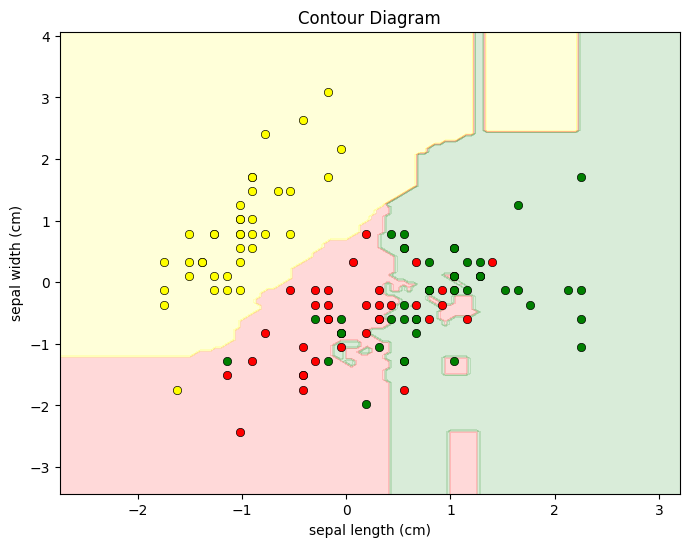

In [10]:
# inspect decision boundaries for different k
plot_decision_boundaries(
    X_train, y_train, knn, "sepal length (cm)", "sepal width (cm)"
)

In the next section, we will investigate more complex classification models.

## Decision Trees

To get started, we will look at a simple decision tree for classifying the type of Iris.

In [11]:
# re-load data
X = iris.data
y = iris.target
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)

In [12]:
# create and train tree
tree_clf = DecisionTreeClassifier(
    criterion="gini"
)  # else: criterion='entropy'
tree_clf = tree_clf.fit(X_train, y_train)

In [50]:
# compute accuracy
y_pred = tree_clf.predict(X_test)
accuracy_score(y_test, y_pred)

0.9666666666666667

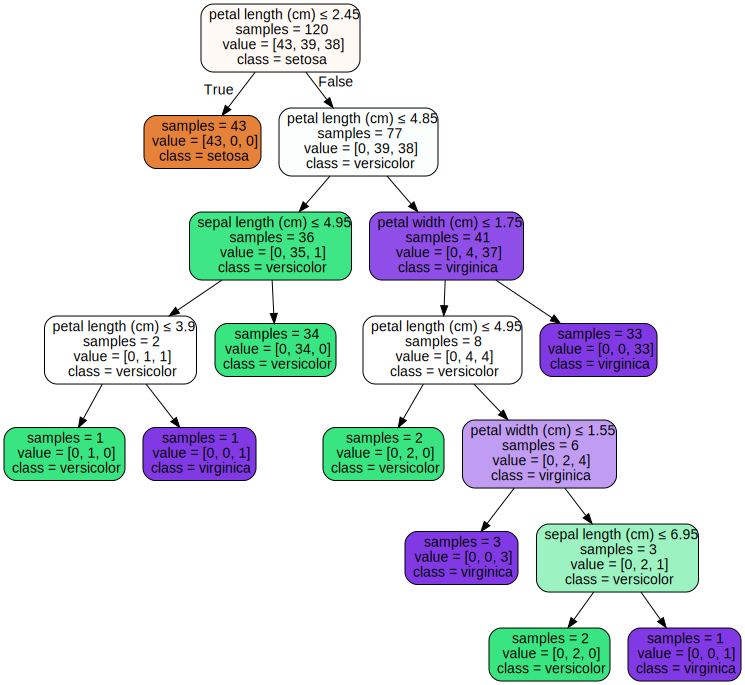

In [13]:
# inspect resulting tree
tree_data = export_graphviz(
    tree_clf,
    class_names=iris.target_names,
    feature_names=iris.feature_names,
    impurity=False,
    filled=True,
    rounded=True,
    special_characters=True,
)
graph = graphviz.Source(tree_data)
graph

## Ensembles

In [14]:
# Random Forest (bagging)
rf_clf = RandomForestClassifier(n_estimators=200, max_depth=3, random_state=0)
rf_clf = rf_clf.fit(X_train, y_train)

In [15]:
# Extremely randomized forests (bagging)
et_clf = ExtraTreesClassifier(
    n_estimators=10, max_depth=None, min_samples_split=2, random_state=0
)
et_clf = rf_clf.fit(X_train, y_train)

In [16]:
# Adaboost (boosting)
ab_clf = AdaBoostClassifier(n_estimators=100, random_state=0)
ab_clf = ab_clf.fit(X_train, y_train)

In [17]:
# XGBoost (gradient boosted trees)
xgb_clf = xgb.XGBClassifier(n_estimators=5)
xgb_clf = xgb_clf.fit(X_train, y_train)

## Feature Importance for tree-based models

For tree classifiers, we can also investigate the most important features (as already shown by the tree figure for the DecisionTree classifier). Code adapted from https://scikit-learn.org/stable/auto_examples/ensemble/plot_forest_importances.html.

In [18]:
# compute feature importance for decision tree
feature_importances = tree_clf.feature_importances_
feature_importances
feature_importances = pd.Series(feature_importances, index=iris.feature_names)

array([0.0285138 , 0.        , 0.91449251, 0.05699368])

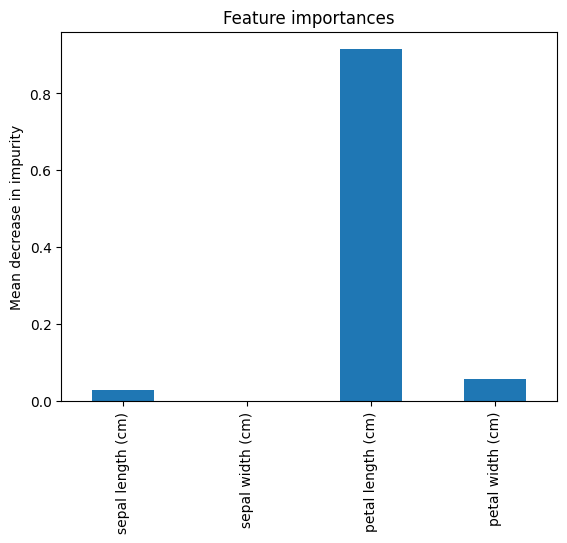

In [19]:
# plot feature importance
fig, ax = plt.subplots()
feature_importances.plot.bar(ax=ax)
ax.set_title("Feature importances")
ax.set_ylabel("Mean decrease in impurity");

We can also compute feature importance for random forest classifiers as follows.

In [20]:
# random forest feature importance
rf_clf = RandomForestClassifier(n_estimators=200, max_depth=3, random_state=0)
rf_clf = rf_clf.fit(X_train, y_train)

In [21]:
# compute feature importance
feature_importances = rf_clf.feature_importances_
feature_importances
feature_importances = pd.Series(feature_importances, index=iris.feature_names)

array([0.09609041, 0.01810068, 0.45418774, 0.43162117])

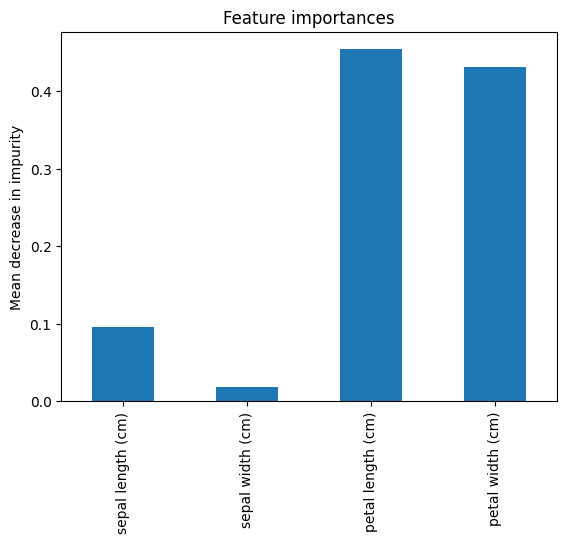

In [22]:
# plot feature importance
fig, ax = plt.subplots()
feature_importances.plot.bar(ax=ax)
ax.set_title("Feature importances")
ax.set_ylabel("Mean decrease in impurity");

In [23]:
# xgboost feature importance
xgb_clf = xgb.XGBClassifier(n_estimators=5)
xgb_clf = xgb_clf.fit(X_train, y_train)

In [24]:
feature_importances = xgb_clf.feature_importances_
feature_importances
feature_importances = pd.Series(feature_importances, index=iris.feature_names)

array([0.        , 0.        , 0.9347587 , 0.06524126], dtype=float32)

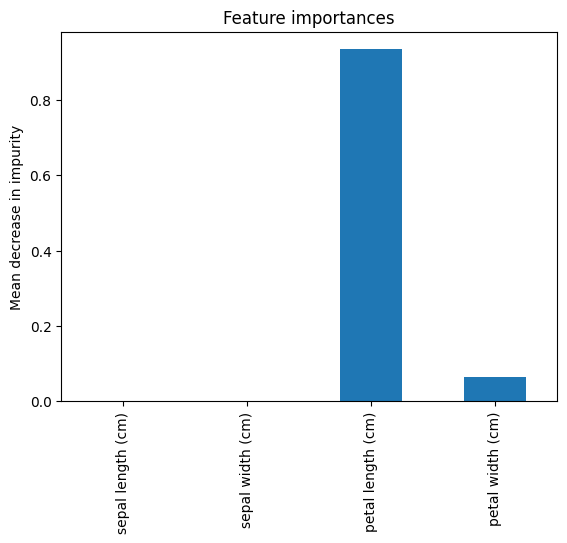

In [25]:
# plot feature importance
fig, ax = plt.subplots()
feature_importances.plot.bar(ax=ax)
ax.set_title("Feature importances")
ax.set_ylabel("Mean decrease in impurity");

## Permutation Importance

In [74]:
permutation_result = permutation_importance(rf_clf, X_train, y_train, n_repeats=30, random_state=0)
permutation_result

{'importances_mean': array([-0.00055556,  0.        ,  0.23888889,  0.12472222]),
 'importances_std': array([0.00566558, 0.        , 0.02799912, 0.02400649]),
 'importances': array([[ 0.        ,  0.        ,  0.        ,  0.00833333,  0.        ,
          0.        , -0.00833333,  0.        , -0.00833333,  0.        ,
          0.        ,  0.        ,  0.00833333,  0.00833333, -0.00833333,
         -0.00833333,  0.        , -0.00833333,  0.00833333, -0.00833333,
          0.00833333,  0.00833333,  0.        ,  0.        , -0.00833333,
          0.        ,  0.        , -0.00833333,  0.        ,  0.        ],
        [ 0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
          0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
          0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
          0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
          0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
          0

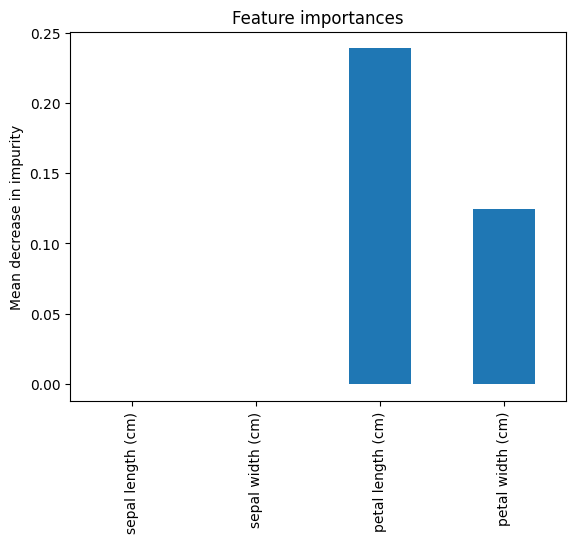

In [75]:
permutation_importances =  pd.Series(permutation_result.importances_mean, index=iris.feature_names)
# plot feature importance
fig, ax = plt.subplots()
permutation_importances.plot.bar(ax=ax)
ax.set_title("Feature importances")
ax.set_ylabel("Mean decrease in impurity");

### Fashion MNIST Example

Now we will focus on a larger dataset: Fashion MNIST (as already used in the tutorials).

In [26]:
# load data (alternatively, we could also load data via keras or hugging face).
fashion_mnist = pd.read_csv(
    os.path.join(data_dir, "fashion-mnist_train.csv"),
)
len(fashion_mnist)

60000

fashion_mnist

In [27]:
# use a sample of training data (for the sake of runtime)
fashion_mnist = fashion_mnist.sample(1000)

In [28]:
y = fashion_mnist["label"]
y = label_binarize(
    y, classes=[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10]
)  # binarize labels s.t. we are able to use scoring functions in the following
X = fashion_mnist.drop(["label"], axis=1)

In the following, we are going to employ a set of decision tree/ensemble-based classification algorithms, optimize their hyperparameters and compare the resulting evaluation metrics.

<div class="alert alert-block alert-info">
<b>Note:</b> Running the following grid searches takes quite some time.</div>

In [29]:
# specify metrics to be computed
scoring = {
    "accuracy": "accuracy",
    "precision_micro": "precision_micro",
    "recall_micro": "recall_micro",
}

In [30]:
# grid search for knn (baseline)
parameters_knn = {"n_neighbors": range(5, 50, 10), "algorithm": ["auto"]}

# apply grid search
gs_knn = GridSearchCV(
    KNeighborsClassifier(),
    parameters_knn,
    cv=5,
    refit="accuracy",
    scoring=scoring,
    verbose=3,
)
gs_knn.fit(X, y)

# best results
print(
    f"Best parameter for knn (CV score={gs_knn.best_score_:0.3f}):\
      {gs_knn.best_params_} ({gs_knn.best_estimator_})"
)

Fitting 5 folds for each of 5 candidates, totalling 25 fits
[CV 1/5] END algorithm=auto, n_neighbors=5; accuracy: (test=0.685) precision_micro: (test=0.765) recall_micro: (test=0.685) total time=   0.3s
[CV 2/5] END algorithm=auto, n_neighbors=5; accuracy: (test=0.695) precision_micro: (test=0.799) recall_micro: (test=0.695) total time=   0.2s
[CV 3/5] END algorithm=auto, n_neighbors=5; accuracy: (test=0.730) precision_micro: (test=0.820) recall_micro: (test=0.730) total time=   0.2s
[CV 4/5] END algorithm=auto, n_neighbors=5; accuracy: (test=0.650) precision_micro: (test=0.734) recall_micro: (test=0.650) total time=   0.2s
[CV 5/5] END algorithm=auto, n_neighbors=5; accuracy: (test=0.710) precision_micro: (test=0.772) recall_micro: (test=0.710) total time=   0.2s
[CV 1/5] END algorithm=auto, n_neighbors=15; accuracy: (test=0.635) precision_micro: (test=0.809) recall_micro: (test=0.635) total time=   0.2s
[CV 2/5] END algorithm=auto, n_neighbors=15; accuracy: (test=0.665) precision_mic

GridSearchCV(cv=5, estimator=KNeighborsClassifier(),
             param_grid={'algorithm': ['auto'],
                         'n_neighbors': range(5, 50, 10)},
             refit='accuracy',
             scoring={'accuracy': 'accuracy',
                      'precision_micro': 'precision_micro',
                      'recall_micro': 'recall_micro'},
             verbose=3)

Best parameter for knn (CV score=0.694):      {'algorithm': 'auto', 'n_neighbors': 5} (KNeighborsClassifier())


In [31]:
pd.DataFrame(gs_knn.cv_results_)

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_algorithm,param_n_neighbors,params,split0_test_accuracy,split1_test_accuracy,split2_test_accuracy,split3_test_accuracy,split4_test_accuracy,mean_test_accuracy,std_test_accuracy,rank_test_accuracy,...,split1_test_precision_micro,split2_test_precision_micro,split3_test_precision_micro,split4_test_precision_micro,mean_test_precision_micro,std_test_precision_micro,rank_test_precision_micro,split0_test_recall_micro,split1_test_recall_micro,split2_test_recall_micro,split3_test_recall_micro,split4_test_recall_micro,mean_test_recall_micro,std_test_recall_micro,rank_test_recall_micro
0,0.011104,0.005041,0.198227,0.035401,auto,5,"{'algorithm': 'auto', 'n_neighbors': 5}",0.685,0.695,0.730,0.650,0.710,0.694,0.026721,1,...,0.798851,0.820225,0.734463,0.771739,0.778128,0.029366,5,0.685,0.695,0.730,0.650,0.710,0.694,0.026721,1
1,0.009623,0.002640,0.178316,0.009299,auto,15,"{'algorithm': 'auto', 'n_neighbors': 15}",0.635,0.665,0.680,0.620,0.685,0.657,0.025417,2,...,0.826087,0.855346,0.815789,0.810651,0.823358,0.017076,4,0.635,0.665,0.680,0.620,0.685,0.657,0.025417,2
2,0.008367,0.000141,0.177179,0.005679,auto,25,"{'algorithm': 'auto', 'n_neighbors': 25}",0.600,0.650,0.615,0.585,0.665,0.623,0.030100,3,...,0.860927,0.872340,0.823944,0.826087,0.843326,0.019618,3,0.600,0.650,0.615,0.585,0.665,0.623,0.030100,3
3,0.008424,0.000227,0.185982,0.010549,auto,35,"{'algorithm': 'auto', 'n_neighbors': 35}",0.565,0.590,0.555,0.515,0.590,0.563,0.027677,4,...,0.867647,0.867188,0.830645,0.836879,0.845435,0.018350,2,0.565,0.590,0.555,0.515,0.590,0.563,0.027677,4
4,0.008678,0.000169,0.181019,0.006526,auto,45,"{'algorithm': 'auto', 'n_neighbors': 45}",0.510,0.570,0.530,0.485,0.550,0.529,0.029732,5,...,0.883721,0.876033,0.850877,0.846154,0.857211,0.020001,1,0.510,0.570,0.530,0.485,0.550,0.529,0.029732,5


In [32]:
# grid search for decision tree
parameters_decision_tree = {
    "criterion": ["entropy", "gini"],
    "max_depth": [6, 8, 10, 12],
}

# apply grid search
gs_decision_tree = GridSearchCV(
    DecisionTreeClassifier(),
    parameters_decision_tree,
    cv=5,
    scoring=scoring,
    refit="accuracy",
    verbose=3,
)
gs_decision_tree.fit(X, y)

# best results
print(
    f"Best parameter for decision tree \
    (CV score={gs_decision_tree.best_score_:0.3f}): \
    {gs_decision_tree.best_params_} ({gs_decision_tree.best_estimator_})"
)

Fitting 5 folds for each of 8 candidates, totalling 40 fits
[CV 1/5] END criterion=entropy, max_depth=6; accuracy: (test=0.650) precision_micro: (test=0.718) recall_micro: (test=0.650) total time=   1.0s
[CV 2/5] END criterion=entropy, max_depth=6; accuracy: (test=0.675) precision_micro: (test=0.734) recall_micro: (test=0.675) total time=   0.8s
[CV 3/5] END criterion=entropy, max_depth=6; accuracy: (test=0.665) precision_micro: (test=0.731) recall_micro: (test=0.665) total time=   0.6s
[CV 4/5] END criterion=entropy, max_depth=6; accuracy: (test=0.540) precision_micro: (test=0.639) recall_micro: (test=0.540) total time=   0.6s
[CV 5/5] END criterion=entropy, max_depth=6; accuracy: (test=0.640) precision_micro: (test=0.699) recall_micro: (test=0.640) total time=   0.6s
[CV 1/5] END criterion=entropy, max_depth=8; accuracy: (test=0.635) precision_micro: (test=0.676) recall_micro: (test=0.635) total time=   0.7s
[CV 2/5] END criterion=entropy, max_depth=8; accuracy: (test=0.685) precisio

GridSearchCV(cv=5, estimator=DecisionTreeClassifier(),
             param_grid={'criterion': ['entropy', 'gini'],
                         'max_depth': [6, 8, 10, 12]},
             refit='accuracy',
             scoring={'accuracy': 'accuracy',
                      'precision_micro': 'precision_micro',
                      'recall_micro': 'recall_micro'},
             verbose=3)

Best parameter for decision tree     (CV score=0.682):     {'criterion': 'entropy', 'max_depth': 12} (DecisionTreeClassifier(criterion='entropy', max_depth=12))


In [33]:
# grid search for random forests
parameters_random_forest = {
    "n_estimators": range(100, 600, 100),
}

# apply grid search
gs_random_forest = GridSearchCV(
    RandomForestClassifier(),
    parameters_random_forest,
    cv=5,
    scoring=scoring,
    refit="accuracy",
    verbose=3,
)
gs_random_forest.fit(X, y)

# best results
print(
    f"Best parameter for random forest \
    (CV score={gs_random_forest.best_score_:0.3f}): \
      {gs_random_forest.best_params_} ({gs_random_forest.best_estimator_})"
)

Fitting 5 folds for each of 5 candidates, totalling 25 fits
[CV 1/5] END n_estimators=100; accuracy: (test=0.630) precision_micro: (test=0.881) recall_micro: (test=0.630) total time=   1.5s
[CV 2/5] END n_estimators=100; accuracy: (test=0.690) precision_micro: (test=0.890) recall_micro: (test=0.690) total time=   1.4s
[CV 3/5] END n_estimators=100; accuracy: (test=0.670) precision_micro: (test=0.893) recall_micro: (test=0.670) total time=   1.5s
[CV 4/5] END n_estimators=100; accuracy: (test=0.585) precision_micro: (test=0.836) recall_micro: (test=0.585) total time=   1.4s
[CV 5/5] END n_estimators=100; accuracy: (test=0.680) precision_micro: (test=0.907) recall_micro: (test=0.680) total time=   1.4s
[CV 1/5] END n_estimators=200; accuracy: (test=0.665) precision_micro: (test=0.881) recall_micro: (test=0.665) total time=   3.1s
[CV 2/5] END n_estimators=200; accuracy: (test=0.690) precision_micro: (test=0.890) recall_micro: (test=0.690) total time=   3.1s
[CV 3/5] END n_estimators=200;

GridSearchCV(cv=5, estimator=RandomForestClassifier(),
             param_grid={'n_estimators': range(100, 600, 100)},
             refit='accuracy',
             scoring={'accuracy': 'accuracy',
                      'precision_micro': 'precision_micro',
                      'recall_micro': 'recall_micro'},
             verbose=3)

Best parameter for random forest     (CV score=0.672):       {'n_estimators': 200} (RandomForestClassifier(n_estimators=200))


In [34]:
# grid search for extra trees
parameters_extra_trees = {
    "n_estimators": range(100, 600, 100),
}

# apply grid search
gs_extra_trees = GridSearchCV(
    ExtraTreesClassifier(),
    parameters_extra_trees,
    cv=5,
    scoring=scoring,
    refit="accuracy",
    verbose=3,
)
gs_extra_trees.fit(X, y)

# best results
print(
    f"Best parameter for extra trees \
    (CV score={gs_extra_trees.best_score_:0.3f}): \
      {gs_extra_trees.best_params_} ({gs_extra_trees.best_estimator_})"
)

Fitting 5 folds for each of 5 candidates, totalling 25 fits
[CV 1/5] END n_estimators=100; accuracy: (test=0.640) precision_micro: (test=0.877) recall_micro: (test=0.640) total time=   0.7s
[CV 2/5] END n_estimators=100; accuracy: (test=0.685) precision_micro: (test=0.895) recall_micro: (test=0.685) total time=   0.6s
[CV 3/5] END n_estimators=100; accuracy: (test=0.685) precision_micro: (test=0.932) recall_micro: (test=0.685) total time=   0.6s
[CV 4/5] END n_estimators=100; accuracy: (test=0.605) precision_micro: (test=0.852) recall_micro: (test=0.605) total time=   0.6s
[CV 5/5] END n_estimators=100; accuracy: (test=0.675) precision_micro: (test=0.900) recall_micro: (test=0.675) total time=   0.7s
[CV 1/5] END n_estimators=200; accuracy: (test=0.665) precision_micro: (test=0.905) recall_micro: (test=0.665) total time=   1.2s
[CV 2/5] END n_estimators=200; accuracy: (test=0.690) precision_micro: (test=0.920) recall_micro: (test=0.690) total time=   1.3s
[CV 3/5] END n_estimators=200;

GridSearchCV(cv=5, estimator=ExtraTreesClassifier(),
             param_grid={'n_estimators': range(100, 600, 100)},
             refit='accuracy',
             scoring={'accuracy': 'accuracy',
                      'precision_micro': 'precision_micro',
                      'recall_micro': 'recall_micro'},
             verbose=3)

Best parameter for extra trees     (CV score=0.671):       {'n_estimators': 300} (ExtraTreesClassifier(n_estimators=300))


In [35]:
# grid search for extreme gradient boosting trees,
# xgboost library adheres to sklearn interfaces
parameters_xgboost = {
    "n_estimators": range(
        100, 200, 100
    ),  # only use up to 200 trees for the sake of computation time
}

# apply grid search, xgboost requires us to use explicit labels
# (not using an encoder as previously)
gs_xgboost = GridSearchCV(
    xgb.XGBClassifier(n_jobs=-1),
    parameters_xgboost,
    cv=5,
    scoring=scoring,
    refit="accuracy",
    verbose=3,
)
gs_xgboost.fit(X, fashion_mnist["label"])

# best results
print(
    f"Best parameter for xgboost (CV score={gs_xgboost.best_score_:0.3f}): \
    {gs_xgboost.best_params_} ({gs_xgboost.best_estimator_})"
)

Fitting 5 folds for each of 1 candidates, totalling 5 fits


/home/eva/.local/share/virtualenvs/data-engineering-analytics-notebooks-Qx0adyYX/lib/python3.10/site-packages/xgboost/data.py:335: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(dtype):
/home/eva/.local/share/virtualenvs/data-engineering-analytics-notebooks-Qx0adyYX/lib/python3.10/site-packages/xgboost/data.py:338: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  is_categorical_dtype(dtype) or is_pa_ext_categorical_dtype(dtype)
/home/eva/.local/share/virtualenvs/data-engineering-analytics-notebooks-Qx0adyYX/lib/python3.10/site-packages/xgboost/data.py:384: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if is_categorical_dtype(dtype):
/home/eva/.local/share/virtualenvs/data-engineering-analytics-notebooks-Q

[CV 1/5] END n_estimators=100; accuracy: (test=0.780) precision_micro: (test=0.780) recall_micro: (test=0.780) total time=  12.6s


/home/eva/.local/share/virtualenvs/data-engineering-analytics-notebooks-Qx0adyYX/lib/python3.10/site-packages/xgboost/data.py:335: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(dtype):
/home/eva/.local/share/virtualenvs/data-engineering-analytics-notebooks-Qx0adyYX/lib/python3.10/site-packages/xgboost/data.py:338: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  is_categorical_dtype(dtype) or is_pa_ext_categorical_dtype(dtype)
/home/eva/.local/share/virtualenvs/data-engineering-analytics-notebooks-Qx0adyYX/lib/python3.10/site-packages/xgboost/data.py:384: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if is_categorical_dtype(dtype):
/home/eva/.local/share/virtualenvs/data-engineering-analytics-notebooks-Q

[CV 2/5] END n_estimators=100; accuracy: (test=0.805) precision_micro: (test=0.805) recall_micro: (test=0.805) total time=  12.2s


/home/eva/.local/share/virtualenvs/data-engineering-analytics-notebooks-Qx0adyYX/lib/python3.10/site-packages/xgboost/data.py:335: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(dtype):
/home/eva/.local/share/virtualenvs/data-engineering-analytics-notebooks-Qx0adyYX/lib/python3.10/site-packages/xgboost/data.py:338: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  is_categorical_dtype(dtype) or is_pa_ext_categorical_dtype(dtype)
/home/eva/.local/share/virtualenvs/data-engineering-analytics-notebooks-Qx0adyYX/lib/python3.10/site-packages/xgboost/data.py:384: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if is_categorical_dtype(dtype):
/home/eva/.local/share/virtualenvs/data-engineering-analytics-notebooks-Q

[CV 3/5] END n_estimators=100; accuracy: (test=0.805) precision_micro: (test=0.805) recall_micro: (test=0.805) total time=  17.1s


/home/eva/.local/share/virtualenvs/data-engineering-analytics-notebooks-Qx0adyYX/lib/python3.10/site-packages/xgboost/data.py:335: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(dtype):
/home/eva/.local/share/virtualenvs/data-engineering-analytics-notebooks-Qx0adyYX/lib/python3.10/site-packages/xgboost/data.py:338: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  is_categorical_dtype(dtype) or is_pa_ext_categorical_dtype(dtype)
/home/eva/.local/share/virtualenvs/data-engineering-analytics-notebooks-Qx0adyYX/lib/python3.10/site-packages/xgboost/data.py:384: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if is_categorical_dtype(dtype):
/home/eva/.local/share/virtualenvs/data-engineering-analytics-notebooks-Q

[CV 4/5] END n_estimators=100; accuracy: (test=0.730) precision_micro: (test=0.730) recall_micro: (test=0.730) total time=  19.0s


/home/eva/.local/share/virtualenvs/data-engineering-analytics-notebooks-Qx0adyYX/lib/python3.10/site-packages/xgboost/data.py:335: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(dtype):
/home/eva/.local/share/virtualenvs/data-engineering-analytics-notebooks-Qx0adyYX/lib/python3.10/site-packages/xgboost/data.py:338: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  is_categorical_dtype(dtype) or is_pa_ext_categorical_dtype(dtype)
/home/eva/.local/share/virtualenvs/data-engineering-analytics-notebooks-Qx0adyYX/lib/python3.10/site-packages/xgboost/data.py:384: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if is_categorical_dtype(dtype):
/home/eva/.local/share/virtualenvs/data-engineering-analytics-notebooks-Q

[CV 5/5] END n_estimators=100; accuracy: (test=0.795) precision_micro: (test=0.795) recall_micro: (test=0.795) total time=  16.6s


/home/eva/.local/share/virtualenvs/data-engineering-analytics-notebooks-Qx0adyYX/lib/python3.10/site-packages/xgboost/data.py:335: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(dtype):
/home/eva/.local/share/virtualenvs/data-engineering-analytics-notebooks-Qx0adyYX/lib/python3.10/site-packages/xgboost/data.py:338: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  is_categorical_dtype(dtype) or is_pa_ext_categorical_dtype(dtype)
/home/eva/.local/share/virtualenvs/data-engineering-analytics-notebooks-Qx0adyYX/lib/python3.10/site-packages/xgboost/data.py:384: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if is_categorical_dtype(dtype):
/home/eva/.local/share/virtualenvs/data-engineering-analytics-notebooks-Q

GridSearchCV(cv=5,
             estimator=XGBClassifier(base_score=None, booster=None,
                                     callbacks=None, colsample_bylevel=None,
                                     colsample_bynode=None,
                                     colsample_bytree=None, device=None,
                                     early_stopping_rounds=None,
                                     enable_categorical=False, eval_metric=None,
                                     feature_types=None, gamma=None,
                                     grow_policy=None, importance_type=None,
                                     interaction_constraints=None,
                                     learning_rate=None,...
                                     max_delta_step=None, max_depth=None,
                                     max_leaves=None, min_child_weight=None,
                                     missing=nan, monotone_constraints=None,
                                     multi_strategy=None, n_estimators=None,
                                     n_jobs=-1, num_parallel_tree=None,
                                     random_state=None, ...),
             param_grid={'n_estimators': range(100, 200, 100)},
             refit='accuracy',
             scoring={'accuracy': 'accuracy',
                      'precision_micro': 'precision_micro',
                      'recall_micro': 'recall_micro'},
             verbose=3)

Best parameter for xgboost (CV score=0.783):     {'n_estimators': 100} (XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=None, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=None, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              multi_strategy=None, n_estimators=100, n_jobs=-1,
              num_parallel_tree=None, objective='multi:softprob', ...))


In [36]:
# collect results
result_overview = {}
estimator_labels = [
    "knn",
    "decision tree",
    "extraTree",
    "random forest",
    "xgboost",
]
for score in scoring:
    result_overview[score] = []
    for gs in [
        gs_knn,
        gs_decision_tree,
        gs_extra_trees,
        gs_random_forest,
        gs_xgboost,
    ]:
        result_overview[score].append(
            gs.cv_results_["mean_test_" + score].mean()
        )

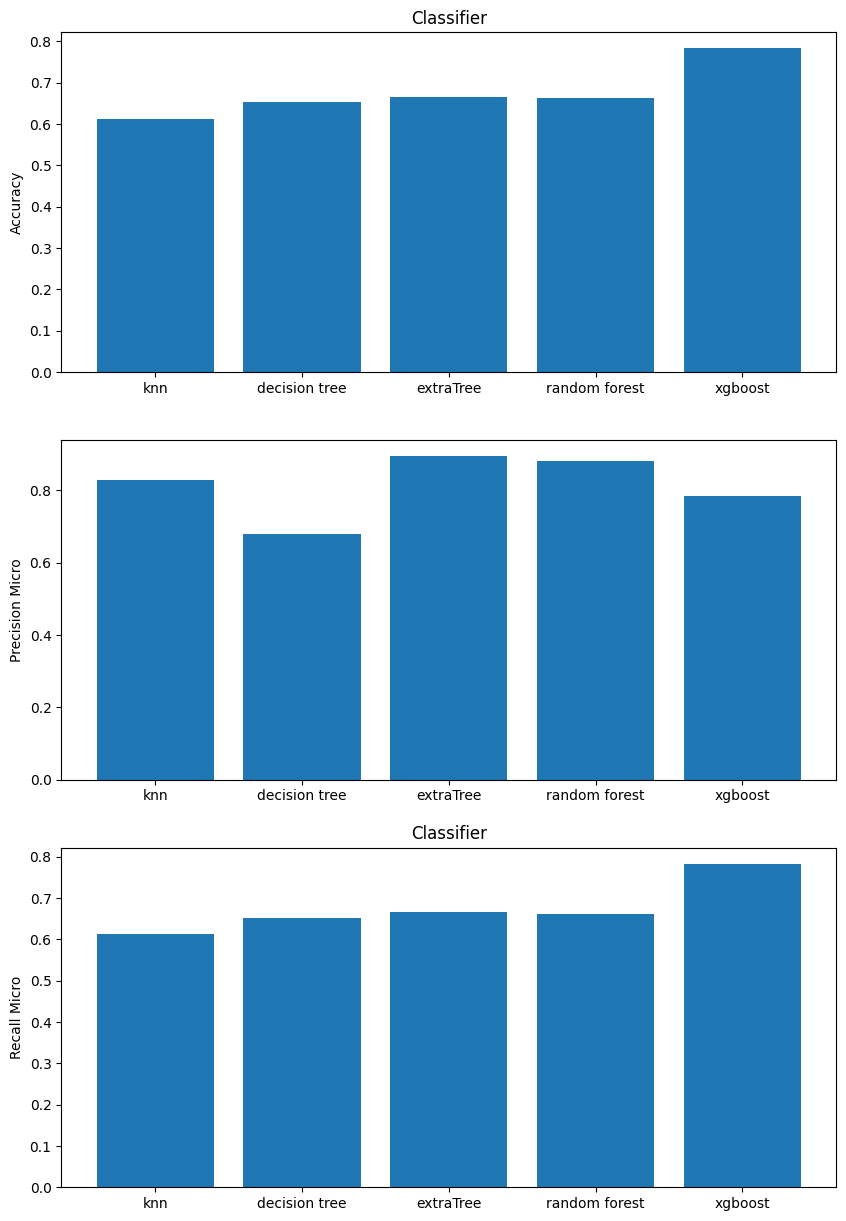

In [37]:
fig, (ax1, ax2, ax3) = plt.subplots(3, figsize=(10, 15))
ax1.bar(estimator_labels, result_overview["accuracy"])
ax1.set_ylabel("Accuracy")
ax1.set_title("Classifier")
ax2.bar(estimator_labels, result_overview["precision_micro"])
ax2.set_ylabel("Precision Micro")
ax3.bar(estimator_labels, result_overview["recall_micro"])
plt.ylabel("Recall Micro")
plt.title("Classifier");

# Feature Selection

In [38]:
# set up data
X = iris.data
y = iris.target

# preprocess
# scaler = StandardScaler()
# X = scaler.fit_transform(X)

# split data into training and test
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)

## Filtering Methods

We have already covered the variance of features in the lecture (and notebook) on EDA. Similarly, we have already covered the pairwise correlation of features and also the correlation between variables and the target variable in our lecture (and notebook) on linear regression. 

A handy method in this regards is scikit's `VarianceThreshold` method that removes all variables with a variance below a given threshold.

In [39]:
feature_selector = VarianceThreshold(0.6)
feature_selector.fit_transform(X)

array([[5.1, 1.4],
       [4.9, 1.4],
       [4.7, 1.3],
       [4.6, 1.5],
       [5. , 1.4],
       [5.4, 1.7],
       [4.6, 1.4],
       [5. , 1.5],
       [4.4, 1.4],
       [4.9, 1.5],
       [5.4, 1.5],
       [4.8, 1.6],
       [4.8, 1.4],
       [4.3, 1.1],
       [5.8, 1.2],
       [5.7, 1.5],
       [5.4, 1.3],
       [5.1, 1.4],
       [5.7, 1.7],
       [5.1, 1.5],
       [5.4, 1.7],
       [5.1, 1.5],
       [4.6, 1. ],
       [5.1, 1.7],
       [4.8, 1.9],
       [5. , 1.6],
       [5. , 1.6],
       [5.2, 1.5],
       [5.2, 1.4],
       [4.7, 1.6],
       [4.8, 1.6],
       [5.4, 1.5],
       [5.2, 1.5],
       [5.5, 1.4],
       [4.9, 1.5],
       [5. , 1.2],
       [5.5, 1.3],
       [4.9, 1.4],
       [4.4, 1.3],
       [5.1, 1.5],
       [5. , 1.3],
       [4.5, 1.3],
       [4.4, 1.3],
       [5. , 1.6],
       [5.1, 1.9],
       [4.8, 1.4],
       [5.1, 1.6],
       [4.6, 1.4],
       [5.3, 1.5],
       [5. , 1.4],
       [7. , 4.7],
       [6.4, 4.5],
       [6.9,

The information gain for an individual feature can be computed as follows.

In [40]:
feature_importances = mutual_info_classif(X, y)

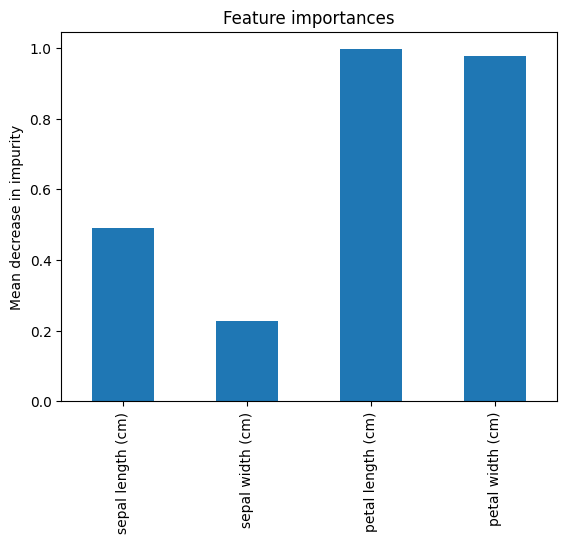

In [41]:
feature_importances = pd.Series(feature_importances, index=iris.feature_names)
# plot feature importance
fig, ax = plt.subplots()
feature_importances.plot.bar(ax=ax)
ax.set_title("Feature importances")
ax.set_ylabel("Mean decrease in impurity");

## Wrapper Methods

Wrapper methods require a classifier/regressor to compute the performance scores. We use a kNN classifier in the following scenario.

In [42]:
knn = KNeighborsClassifier(
    n_neighbors=9, algorithm="kd_tree", leaf_size=30, metric="minkowski", p=1
)
knn.fit(X_train, y_train)

KNeighborsClassifier(algorithm='kd_tree', n_neighbors=9, p=1)

In [43]:
# forward feature selection
sfs = SequentialFeatureSelector(
    knn, k_features=2, forward=True, floating=False, scoring="accuracy", cv=0
)
sfs = sfs.fit(X_train, y_train)

# inspect selected features
print(
    f"Best accuracy score: {sfs.k_score_:.2f}",
)
print(f"Best subsets: {sfs.subsets_}")

Best accuracy score: 0.97
Best subsets: {1: {'feature_idx': (2,), 'cv_scores': array([0.95]), 'avg_score': 0.95, 'feature_names': ('2',)}, 2: {'feature_idx': (0, 2), 'cv_scores': array([0.975]), 'avg_score': 0.975, 'feature_names': ('0', '2')}}


In [44]:
# backward feature selection
sfs = SequentialFeatureSelector(
    knn, k_features=2, forward=False, floating=False, scoring="accuracy", cv=0
)
sfs = sfs.fit(X_train, y_train)

# inspect selected features
print(
    f"Best accuracy score: {sfs.k_score_:.2f}",
)
print(f"Best subsets: {sfs.subsets_}")

Best accuracy score: 0.97
Best subsets: {4: {'feature_idx': (0, 1, 2, 3), 'cv_scores': array([0.96666667]), 'avg_score': 0.9666666666666667, 'feature_names': ('0', '1', '2', '3')}, 3: {'feature_idx': (0, 1, 2), 'cv_scores': array([0.975]), 'avg_score': 0.975, 'feature_names': ('0', '1', '2')}, 2: {'feature_idx': (0, 2), 'cv_scores': array([0.975]), 'avg_score': 0.975, 'feature_names': ('0', '2')}}


In [45]:
# exhaustive feature search
efs = ExhaustiveFeatureSelector(
    knn, min_features=1, max_features=3, scoring="accuracy", cv=0
)
efs = efs.fit(X_train, y_train)

# inspect selected features
print(f"Best accuracy score: {efs.best_score_:.2f}", efs.best_score_)
print(f"Best subset (indices): {efs.best_idx_}")
print(f"Best subsets: {sfs.subsets_}")

Features: 14/14

Best accuracy score: 0.97 0.975
Best subset (indices): (0, 2)
Best subsets: {4: {'feature_idx': (0, 1, 2, 3), 'cv_scores': array([0.96666667]), 'avg_score': 0.9666666666666667, 'feature_names': ('0', '1', '2', '3')}, 3: {'feature_idx': (0, 1, 2), 'cv_scores': array([0.975]), 'avg_score': 0.975, 'feature_names': ('0', '1', '2')}, 2: {'feature_idx': (0, 2), 'cv_scores': array([0.975]), 'avg_score': 0.975, 'feature_names': ('0', '2')}}


In [46]:
# recursive feature elimination
# requires an estimator that provides feature importance, therefore, we switch to decision tree
tree_clf = DecisionTreeClassifier(
    criterion="gini"
)  # else: criterion='entropy'
tree_clf = tree_clf.fit(X_train, y_train)

rfe = RFE(estimator=tree_clf, n_features_to_select=2)
rfe.fit(X_train, y_train)

# inspect selected features
print(f"Ranking of features: {rfe.ranking_}")
print(f"Selection mask: {rfe.support_}")

RFE(estimator=DecisionTreeClassifier(), n_features_to_select=2)

Ranking of features: [2 3 1 1]
Selection mask: [False False  True  True]


## Embedded Methods

See feature importance for tree-based models earlier in this notebook.